# Import libraries


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

import math
import imp
import numpy as np
import tensorflow as tf
import os
import time
import dataprocessing as dp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import skimage.transform
from mpl_toolkits.axes_grid1 import ImageGrid

from Models_3DRFB_Attention_LSTM_Stateful import Model_3D
from Parts import *
import easydict
import csv
import pandas as pd

from sklearn.metrics import accuracy_score

Current cuda device  1
lead phase : [1/2]
ensemble phase : [1/1]
torch.Size([456, 16, 36, 12, 3])
torch.Size([456, 2, 72, 24, 3])
(456, 23)
0.9310454646240869
Save prediction: lead = 0


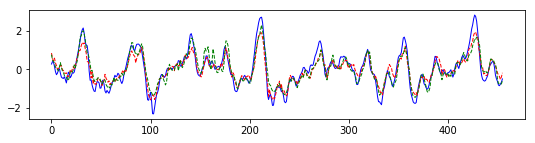

0.9227290281680635
Save prediction: lead = 1


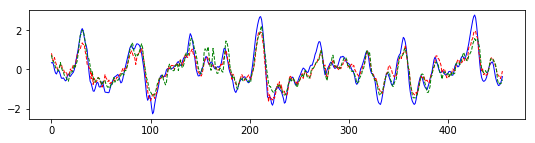

0.8921100925256779
Save prediction: lead = 2


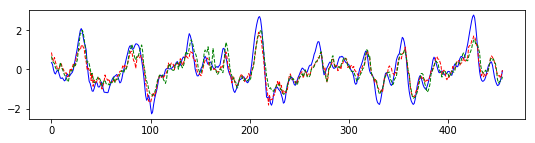

0.8497104213932972
Save prediction: lead = 3


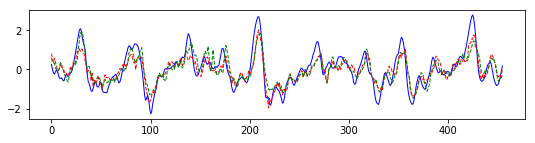

0.8002180621928692
Save prediction: lead = 4


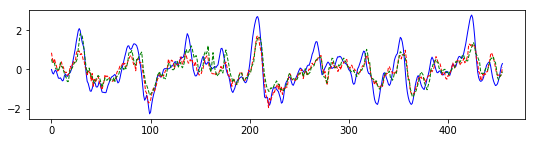

0.7534719836461504
Save prediction: lead = 5


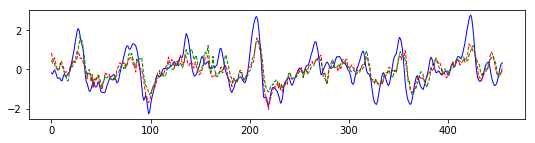

0.7238197822035569
Save prediction: lead = 6


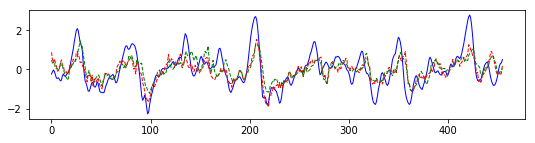

0.6860634153994302
Save prediction: lead = 7


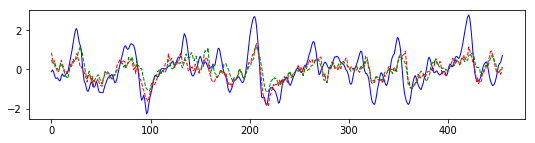

0.6543942863833133
Save prediction: lead = 8


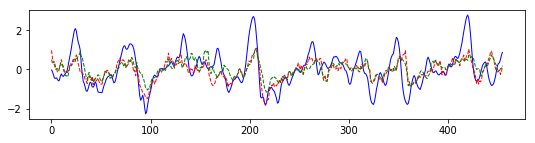

0.6168723778503615
Save prediction: lead = 9


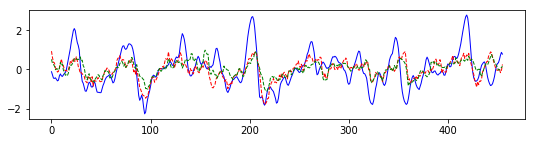

0.5837437138784545
Save prediction: lead = 10


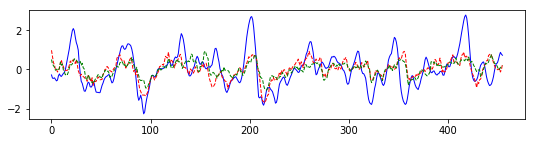

0.553089145226647
Save prediction: lead = 11


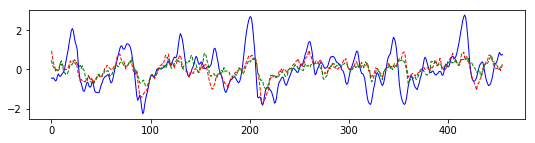

0.522351648302073
Save prediction: lead = 12


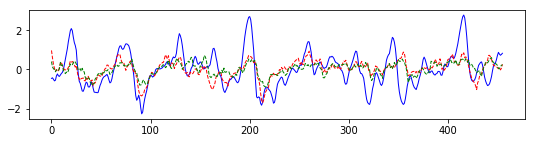

0.48803470719701
Save prediction: lead = 13


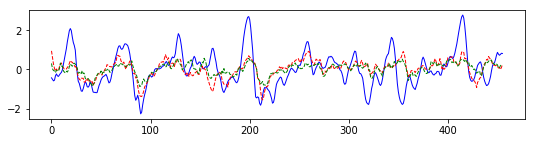

0.462104773239609
Save prediction: lead = 14


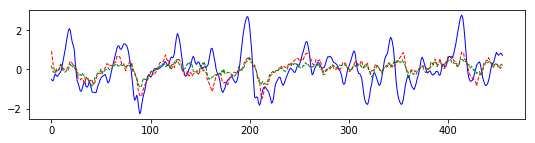

0.4427490971402932
Save prediction: lead = 15


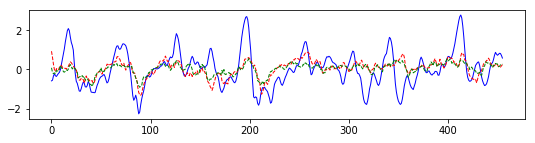

0.42802949817267294
Save prediction: lead = 16


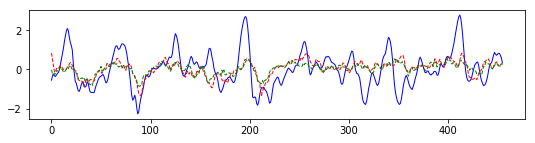

0.4132751933414316
Save prediction: lead = 17


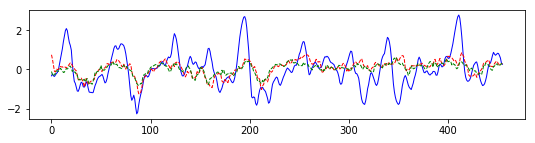

0.38874250015890643
Save prediction: lead = 18


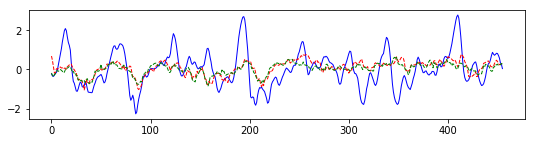

0.3623522018989304
Save prediction: lead = 19


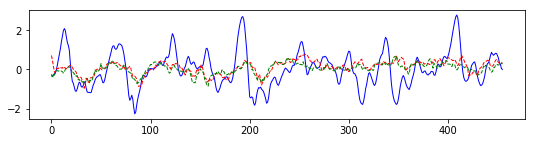

0.33333426585475046
Save prediction: lead = 20


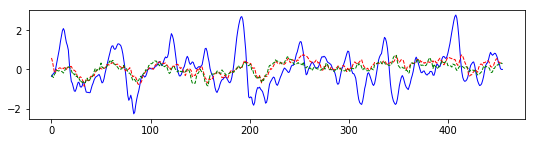

0.3199390556736268
Save prediction: lead = 21


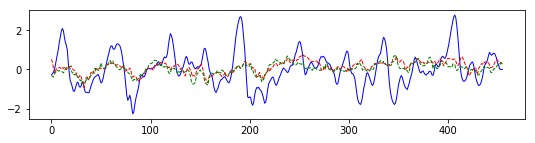

0.30453229545706
Save prediction: lead = 22


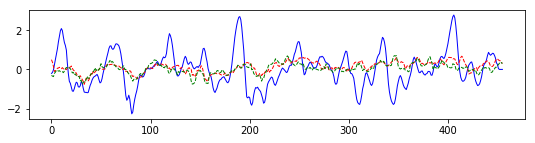

Save classification: lead = 22


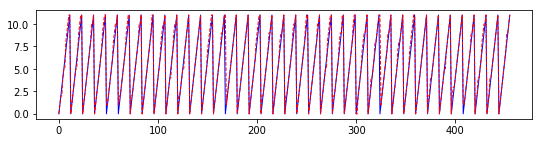

Accuracy = [0.79166667]


In [78]:
if __name__ == "__main__":
    # Random seed 
    # torch.backends.cudnn.deterministic = True 
    # torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)

    # Arguments
    args = easydict.EasyDict({
        "startLead": 1,
        "endLead": 2,
        "gpu": 1,
        "input": 3
    })

    # Directories
    # Dataset for pretrain
    # Folder = "./pretrain_3DRFB_Attention_LSTM_Stateful_relutest_3/"
    # dataFolder = "./" #"./""./"
    Folder = "./pretrain_3DRFB_Attention_LSTM_Stateful_0903_3/"
    # pretrainFolder = ""
    dataFolder = "E:/Projects/ENSO/" #"./"

#     # Dataset for finetuning
#     Folder = "./finetuning_3DRFB_Attention_3"
#     dataFolder = "./"
    
    SSTFile_val = dataFolder+'/Data_validation/godas.input.1980_2017.nc'
    SSTFile_val_label = dataFolder+'/Data_validation/godas.label.1980_2017.nc'

    device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() else 'cpu')
    torch.cuda.set_device(device) # change allocation of current GPU
    print ('Current cuda device ', torch.cuda.current_device()) # check

    # Set Hyper-parameters
    regularizer_rate = 0.00001  #L2 regularization
    numEpoch =  40              # No. Epoch
    learning_rate = 0.0001      # Initial Learning Rate
    n_cycles = 4                # No. cycles in Cosine Annealing
    epochs_per_cycle = math.floor(numEpoch / n_cycles)  # No. epochs for each cycle

    dr = 0.0                   # Dropout rate for Bayesian learning
    tau = 1.0                   # Weight for the batch size in regularization weight calculation (Bayesian learning)
    lengthscale = 1e-2          # Default regularization weight (L2)
    noF = 16                    # Initial No. filters
    num_layer = 256             # Feature size of 1st fully-connected layer
    num_answer = 2              # No. answers(3=3.4/ep/cp)

    ENS_Start = 0
    ENS = 1
    # loop - 1 time only
    for lead in range(args.startLead, args.endLead) :
        print('lead phase : [{}/{}]'.format(lead, args.endLead))

        # Dataset for training
        valset = datasets_general_3D_alllead(SSTFile_val, SSTFile_val_label, lead, sstName='sst', hcName='t300', labelName='pr', noise = False)
        batch_size = len(valset) // 1                             # batch size
        reg = lengthscale**2 * (1 - dr) / (2. * batch_size * tau) # L2 regularization weight for Bayesian learning
        testloader = DataLoader(valset, batch_size = batch_size, shuffle=False)

        test_step = len(testloader)
        assemble_real_type = np.zeros((len(valset)))
        assemble_pred_type = np.zeros((len(valset)))
        assemble_pred_prop = np.zeros((len(valset), 12))

        assemble_real_nino = np.zeros((len(valset), 23))
        assemble_pred_nino = np.zeros((len(valset), 23))
        for ens in range(ENS_Start, ENS) :
            print('ensemble phase : [{}/{}]'.format(ens+1, ENS))

            model = Model_3D(2, noF, num_layer, num_answer, dr, args.input).to(device)
            model.load_state_dict(torch.load('{}/train_{}_{}/train_{}_{}.pth'.format(Folder, lead, ens, lead, ens)))
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=regularizer_rate, betas=(0.9, 0.999))
            model.eval()
            
            bayesianIter = 1

            with torch.no_grad() :
                for i, (batch, ansnino, anstype) in enumerate(testloader):
                    batch = Variable(batch.float().cuda())
                    ansnino = Variable(ansnino.float().cuda())
                    anstype = Variable(anstype.float().cuda())
                    idx = batch_size*i
                    uncertaintyarry_nino = np.zeros((bayesianIter, batch_size, 23))
                    uncertaintyarry_type = np.zeros((bayesianIter, batch_size, 12))
                    for b in range(int(bayesianIter)):
                        output = model(batch) # inference
                        prednino = np.squeeze(output[0], axis=2)
                        uncertaintyarry_nino[b, :, :] = prednino.cpu()
                        uncertaintyarry_type[b, :, :] = torch.nn.functional.softmax(output[1], dim=1).cpu()
                        print(output[3].shape)
                        print(batch.shape)
                        # alpha = output[2].reshape((batch_size, 9, 3, 3, 1))
                        # alpha = alpha.cpu().numpy()
                        # batch = batch.cpu().numpy()
                        # firstConv = output[3].cpu().numpy()
                        # secondConv = output[4].cpu().numpy()
                        # thirdConv = output[5].cpu().numpy()
                        # curTime = 1980
                        # for i in range(batch_size):
#                             plt.imshow(batch[i, 0, :, :, 0].T, cmap='bwr', vmin=-2.0, vmax=2.0)
#                             alphamap = skimage.transform.resize(alpha[i, :, :, 0, 0], [72, 24])
#                             plt.imshow(alphamap.T, alpha=0.3, cmap='Greens', vmin=0.0, vmax=np.max(alphamap)*0.1)
#                             plt.axis('off')
#                             plt.gca().invert_yaxis()
#                             plt.savefig(Folder + "/Attention_" + str(i).zfill(4) + "_"  +  str(0).zfill(2) + ".png", orientation='landscape', bbox_inches='tight')
#                             plt.show()
#                             plt.close()

#                             plt.imshow(batch[i, 0, :, :, 1].T, cmap='bwr', vmin=-2.0, vmax=2.0)
#                             alphamap = skimage.transform.resize(alpha[i, :, :, 1, 0], [72, 24])
#                             plt.imshow(alphamap.T, alpha=0.3, cmap='Greens')
#                             plt.axis('off')
#                             plt.gca().invert_yaxis()
#                             plt.savefig(Folder + "/Attention_" + str(i).zfill(4) + "_"  +  str(1).zfill(2) + ".png", orientation='landscape', bbox_inches='tight')
#                             plt.show()
#                             plt.close()

#                             if i%12 == 0:
#                                 curTime += 1
#                             img = skimage.transform.resize(batch[i, 1, :, :, 2], [72, 24])
#                             plt.imshow(img.T, cmap='bwr', vmin=-1.0, vmax=1.0)
#                             alphamap = skimage.transform.resize(alpha[i, :, :, 2, 0], [72, 24])
# #                             alphamaps[i, :, :, 2] = alphamap
#                             plt.imshow(alphamap.T, alpha=0.5, cmap='Greens', vmin=0.0, vmax=np.max(alphamap))
#                             plt.axis('off')
#                             plt.gca().invert_yaxis()
#                             plt.title('t='+ str(curTime).zfill(4) + "/" + str(i%12+1).zfill(2))
#                             plt.savefig(Folder + "/Attention_" + str(curTime).zfill(4) + "_" + str(i%12+1).zfill(2) + ".png", orientation='landscape', bbox_inches='tight')
#                             plt.show()
#                             plt.close()
                            
#                             maxRate = 0.9
#                             minRate = 0.3
#                             img = skimage.transform.resize(batch[i, 0, :, :, 1], [72, 24])
#                             plt.imshow(img.T, cmap='bwr', vmin=-2.0, vmax=2.0)
#                             featureMap = firstConv[i, :, :, :, 0]
#                             featureMap = np.max(featureMap, axis=0)
#                             featureMap = skimage.transform.resize(featureMap, [72, 24])
#                             plt.imshow(featureMap.T, cmap='Greens', alpha=0.5, vmin=np.max(featureMap)*minRate, vmax=np.max(featureMap)*maxRate)
#                             plt.axis('off')
#                             plt.gca().invert_yaxis()
#                             plt.title('First Block t='+ str(i%12).zfill(2))
#                             plt.savefig(Folder + "/FirstFea_" + str(i).zfill(4) + "_" + str(2).zfill(2) + ".png", orientation='landscape', bbox_inches='tight')
#                             plt.show()
#                             plt.close()
                            
                            
#                             img = skimage.transform.resize(batch[i, 0, :, :, 1], [72, 24])
#                             plt.imshow(img.T, cmap='bwr', vmin=-2.0, vmax=2.0)
#                             featureMap = secondConv[i, :, :, :, 0]
#                             featureMap = np.max(featureMap, axis=0)
#                             featureMap = skimage.transform.resize(featureMap, [72, 24])
#                             plt.imshow(featureMap.T, cmap='Greens', alpha=0.5, vmin=np.max(featureMap)*minRate, vmax=np.max(featureMap)*maxRate)
#                             plt.axis('off')
#                             plt.gca().invert_yaxis()
#                             plt.title('Second Block t='+ str(i%12).zfill(2))
#                             plt.savefig(Folder + "/SecondFea_" + str(i).zfill(4) + "_" + str(2).zfill(2) + ".png", orientation='landscape', bbox_inches='tight')
#                             plt.show()
#                             plt.close()
                            
#                             img = skimage.transform.resize(batch[i, 0, :, :, 1], [72, 24])
#                             plt.imshow(img.T, cmap='bwr', vmin=-2.0, vmax=2.0)
#                             featureMap = thirdConv[i, :, :, :, 0]
#                             featureMap = np.max(featureMap, axis=0)
#                             featureMap = skimage.transform.resize(featureMap, [72, 24])
#                             plt.imshow(featureMap.T, cmap='Greens', alpha=0.5, vmin=np.max(featureMap)*minRate, vmax=np.max(featureMap)*maxRate)
#                             plt.axis('off')
#                             plt.gca().invert_yaxis()
#                             plt.title('Third Block t='+ str(i%12).zfill(2))
#                             plt.savefig(Folder + "/ThirdFea_" + str(i).zfill(4) + "_" + str(2).zfill(2) + ".png", orientation='landscape', bbox_inches='tight')
#                             plt.show()
#                             plt.close()
                    if ens == 0:
                        assemble_real_nino[idx:idx+batch_size, :] = ansnino.cpu().numpy()
                        anstype = torch.argmax(anstype, dim=1).cpu().numpy()
                        assemble_real_type[idx:idx+batch_size] = anstype

                    assemble_pred_nino[idx:idx+batch_size, :] += np.mean(uncertaintyarry_nino, axis=0)
                    predMean = np.mean(uncertaintyarry_type, axis = 0)
                    # assemble_pred_type[idx:idx+batch_size] += np.argmax(predMean, axis = 1)
                    assemble_pred_prop[idx:idx+batch_size, :] += predMean

                    del batch
                    del ansnino
                    del anstype
        
        # End of ensemble
        assemble_pred_nino /= ENS
        assemble_pred_prop /= ENS
        assemble_pred_type = np.argmax(assemble_pred_prop, axis = 1)

        nino34 = open('v01_tr40/C35D50/nino34.gdat', 'r')
        nino34 = np.fromfile(nino34, np.float32)
        nino34 = nino34.reshape(-1, 23)
        print(nino34.shape)
        corr = np.zeros(23)
        stdIdx_Base = 12*0 + 0
        endIdx = stdIdx + 480
        for i in range(23):
            stdIdx = stdIdx_Base
            endIdx = stdIdx + 480
            corr[i] = dp.CorrelationSkill(assemble_real_nino[:, i], assemble_pred_nino[:, i])
            print(corr[i])
            print('Save prediction: lead = {}'.format(i) )
            inputTimeSeq = assemble_real_nino.shape[0]
            dwidth = 800
            dpi = 90
            dheight = 180
            plt.figure(figsize=(dwidth/dpi, dheight/dpi))
            timeValues = np.arange(0, inputTimeSeq)
            plt.plot(timeValues[stdIdx:endIdx], assemble_real_nino[stdIdx:endIdx, i], marker='', color='blue', linewidth=1, label="Measurement")
            plt.plot(timeValues[stdIdx:endIdx], assemble_pred_nino[stdIdx:endIdx, i], marker='', color='red', linewidth=1, linestyle='dashed', label="RFB")
            plt.plot(timeValues[stdIdx:endIdx], nino34[stdIdx:endIdx, i], marker='', color='green', linewidth=1, linestyle='dashed', label="2D")
            plt.savefig(Folder + "/NinoPred_" + str(i).zfill(6) + ".png", orientation='landscape', bbox_inches='tight')
            plt.show()
            plt.close()
        
        np.savetxt(Folder + '/correlation.csv',corr,delimiter=",")
        
        print('Save classification: lead = {}'.format(i) )
        plt.figure(figsize=(dwidth/dpi, dheight/dpi))
        timeValues = np.arange(0, inputTimeSeq)
        plt.plot(timeValues, assemble_real_type, marker='', color='blue', linewidth=1, label="Measurement")
        plt.plot(timeValues, assemble_pred_type, marker='', color='red', linewidth=1, linestyle='dashed', label="Prediction")
        plt.savefig(Folder + "/Month_Classification" + ".png", orientation='landscape', bbox_inches='tight')
        plt.show()
        plt.close()
        accuracy = np.zeros(1)
        accuracy[0] = accuracy_score(assemble_real_type, assemble_pred_type)
        print('Accuracy = {}'.format(accuracy))
        np.savetxt(Folder + '/accuracy.csv',accuracy,delimiter=",")


        # print(assemble_pred_nino)
        np.save("{}/lead_{}_assemble_real_nino".format(Folder, lead), assemble_real_nino) # 길이가 valset인 것이 ensemble 갯수 만큼 들어있음
        np.save("{}/lead_{}_assemble_real_type".format(Folder, lead), assemble_real_type)
        np.save("{}/lead_{}_assemble_pred_nino".format(Folder, lead), assemble_pred_nino)
        np.save("{}/lead_{}_assemble_pred_type".format(Folder, lead), assemble_pred_type)
        np.save("{}/lead_{}_assemble_pred_prop".format(Folder, lead), assemble_pred_prop)



# Main Function
